# Bias vs Variance

Implement regularized linear regression and use it to study models with different bias-variance properties.

In [49]:
import numpy as np
from scipy.io import loadmat
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

## 1 Visualizing the dataset

In [50]:
def load_train(path):
    data = loadmat(path)
    return data['X'], data['y'].ravel()

In [51]:
def load_cv(path):
    data = loadmat(path)
    return data['Xval'], data['yval'].ravel()

In [52]:
def load_test(path):
    data = loadmat(path)
    return data['Xtest'], data['ytest'].ravel()

In [53]:
def transform(X):
    return np.insert(X, 0, values=np.ones(len(X)), axis=1)

In [54]:
X_train_raw, y_train = load_train("ex5data1.mat")
X_train = transform(X_train_raw)
print(X_train.shape)
print(y_train.shape)

(12, 2)
(12,)


Text(0.5, 1.0, 'Train data')

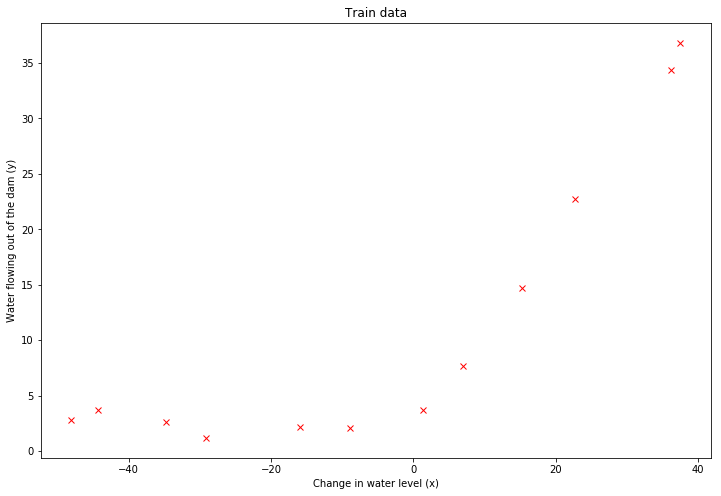

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train_raw, y_train, 'rx')
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
ax.set_title("Train data")

## 2 Regularized linear regression

In [56]:
def cost(theta, X, y):
    return (1 / (2 * len(X))) * np.power((X @ theta) - y, 2).sum()

In [57]:
def regularized_cost(theta, X, y, reg):
    term = (reg / (2 * len(X))) * np.power(theta[1:], 2).sum()
    return cost(theta, X, y) + term

In [58]:
theta = np.ones(2)
regularized_cost(theta, X_train, y_train, 1)

303.9931922202643

In [59]:
def gradient(theta, X, y):
    return (1 / len(X)) * X.T @ ((X @ theta) - y)

In [60]:
def regularized_gradient(theta, X, y, reg):
    term = (reg / len(X)) * theta
    term[0] = 0
    return gradient(theta, X, y) + term

In [61]:
regularized_gradient(theta, X_train, y_train, 1)

array([-15.30301567, 598.25074417])

Fitting linear regression and plotting the best fit line.

In [62]:
def linear_regression(X, y, reg):
    theta = np.ones(X.shape[1])
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, reg),
                       method='TNC',
                       jac=regularized_gradient)
    return res

In [63]:
theta = linear_regression(X_train, y_train, 0).x
theta

array([13.08790364,  0.36777923])

Text(0.5, 1.0, 'Linear regression')

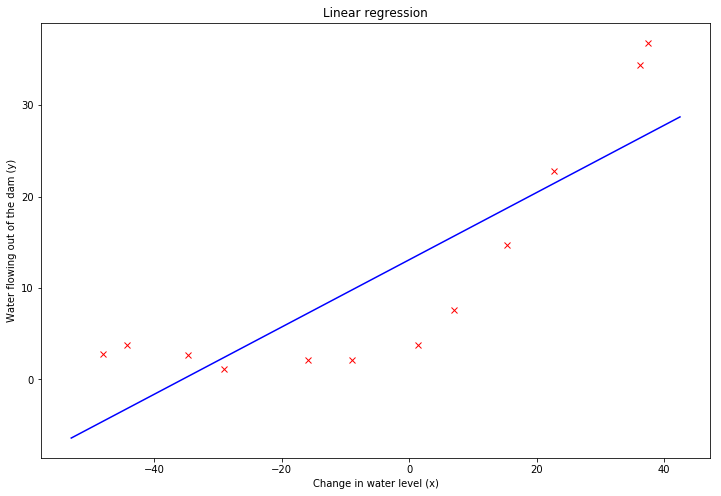

In [64]:
X_raw = np.linspace(X_train_raw.min() - 5, X_train_raw.max() + 5, 100)
X = transform(X_raw.reshape((len(X_raw), 1)))
y = X @ theta

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_raw, y, 'b')
ax.plot(X_train_raw, y_train, 'rx')
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
ax.set_title("Linear regression")

## 3 Learning curve

In [65]:
def get_error(X_train, y_train, X_cv, y_cv, reg):
    e1, e2 = [], []
    for i in range(2, len(y_train) + 1):
        theta = linear_regression(X_train[:i], y_train[:i], reg).x
        e1.append(cost(theta, X_train[:i], y_train[:i]))
        e2.append(cost(theta, X_cv, y_cv))
    return np.array(e1), np.array(e2)

In [66]:
X_cv_raw, y_cv = load_cv("ex5data1.mat")
X_cv = transform(X_cv_raw)

In [67]:
def learning_curve(X_train, y_train, X_cv, y_cv, reg):
    train_error, cv_error = get_error(X_train, y_train, X_cv, y_cv, reg)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(np.arange(2, len(y_train) + 1), train_error, 'r', label='Train')
    ax.plot(np.arange(2, len(y_train) + 1), cv_error, 'b', label='Cross Validation')
    ax.set_xlabel('Size of training examples')
    ax.set_ylabel('error')
    ax.set_title('Learning curve')
    ax.legend(loc=1)

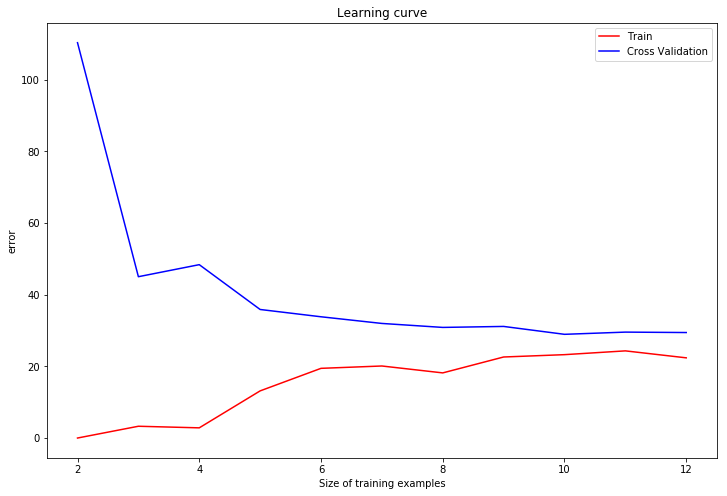

In [68]:
learning_curve(X_train, y_train, X_cv, y_cv, 0)

## 4 Polynomial regression

Turn polynomial terms into features so that we can use linear regression to solve polynomial regression problem

In [69]:
def poly_features(X, power):
    '''
    Maps the original training set X of size (m x 1) into its higher power (m x p)
    '''
    X_poly = X[:]
    for p in range(2, power + 1):
        X_poly = np.insert(X_poly, X_poly.shape[1], values=np.power(X_poly[:, 0], p), axis=1)
    return X_poly

In [70]:
X_train_poly = poly_features(X_train_raw, 3)
X_train_poly

array([[-1.59367581e+01,  2.53980260e+02, -4.04762197e+03],
       [-2.91529792e+01,  8.49896197e+02, -2.47770062e+04],
       [ 3.61895486e+01,  1.30968343e+03,  4.73968522e+04],
       [ 3.74921873e+01,  1.40566411e+03,  5.27014222e+04],
       [-4.80588295e+01,  2.30965109e+03, -1.10999128e+05],
       [-8.94145794e+00,  7.99496701e+01, -7.14866612e+02],
       [ 1.53077929e+01,  2.34328523e+02,  3.58705250e+03],
       [-3.47062658e+01,  1.20452489e+03, -4.18045609e+04],
       [ 1.38915437e+00,  1.92974986e+00,  2.68072045e+00],
       [-4.43837599e+01,  1.96991814e+03, -8.74323736e+04],
       [ 7.01350208e+00,  4.91892115e+01,  3.44988637e+02],
       [ 2.27627489e+01,  5.18142738e+02,  1.17943531e+04]])

Implement feature normalization to prevent features to be badly scaled.

In [71]:
def expand(a, dim):
    return np.tile(a, (dim, 1))

In [72]:
def feature_normalize(X):
    mean = expand(X.mean(axis=0), X.shape[0])
    std = expand(X.std(axis=0, ddof=1), X.shape[0])
    return (X - mean) / std

In [73]:
def plot_polynomial(X_train, y_train, reg):
    theta = linear_regression(X_train, y_train, reg).x
    
    X_raw = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
    X = transform(feature_normalize(poly_features(X_raw.reshape(len(X_raw), 1), 8)))
    y = X @ theta
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X_raw, y, 'b')
    ax.scatter(X_train[:, 1], y_train, c='red', marker='x')
    ax.set_xlabel('Change in water level (x normalized)')
    ax.set_ylabel('Water flowing out of the dam (y)')
    ax.set_title('Polynomial regressioin with $\lambda$ = {}'.format(reg))

In [74]:
X_train_poly = transform(feature_normalize(poly_features(X_train_raw, 8)))
X_cv_poly = transform(feature_normalize(poly_features(X_cv_raw, 8)))

Implement polynomial regression when degree = 8 and $\lambda$ = 0

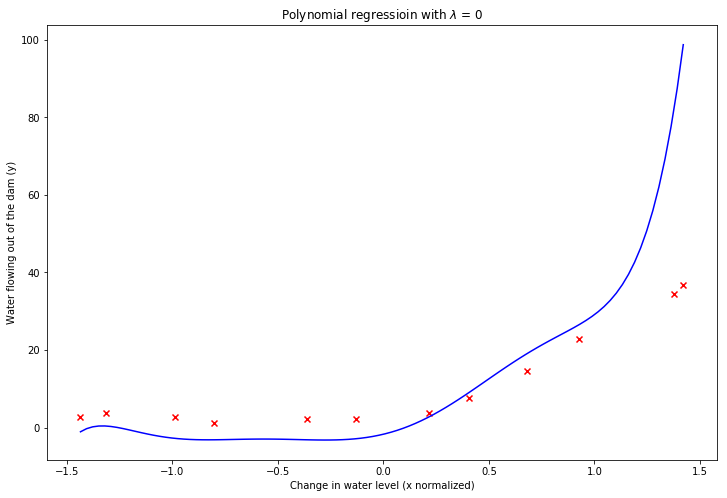

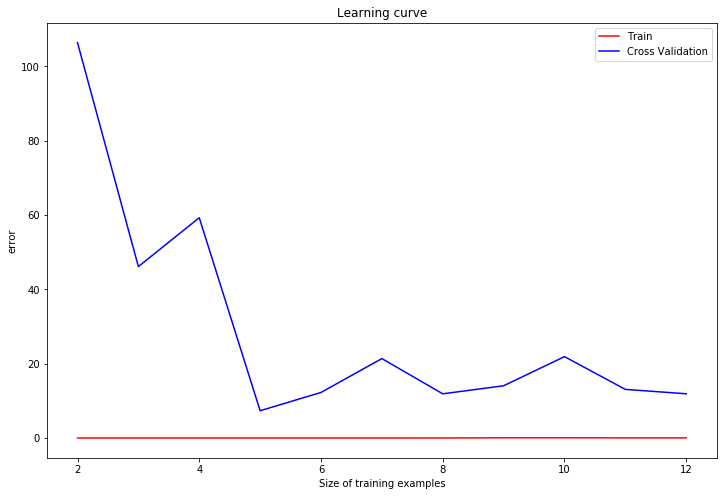

In [75]:
plot_polynomial(X_train_poly, y_train, 0)
learning_curve(X_train_poly, y_train, X_cv_poly, y_cv, 0)

Try $\lambda = 1$

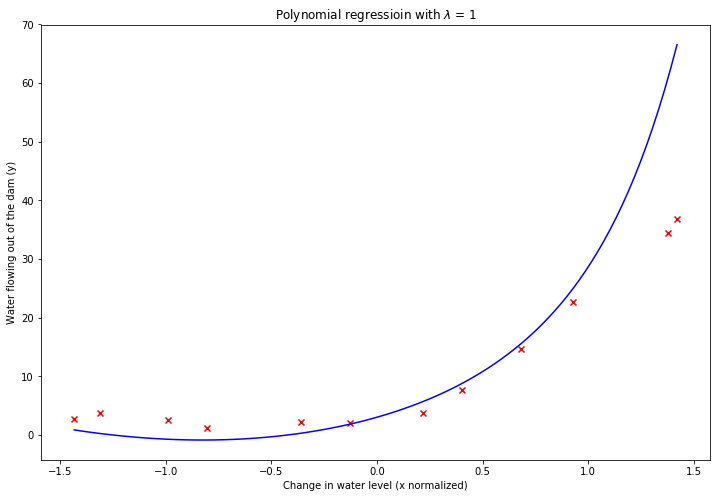

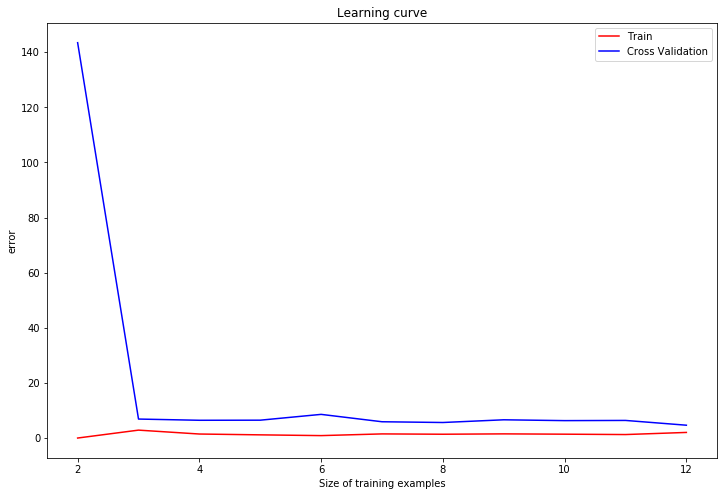

In [76]:
plot_polynomial(X_train_poly, y_train, 1)
learning_curve(X_train_poly, y_train, X_cv_poly, y_cv, 1)

Try $\lambda = 100$

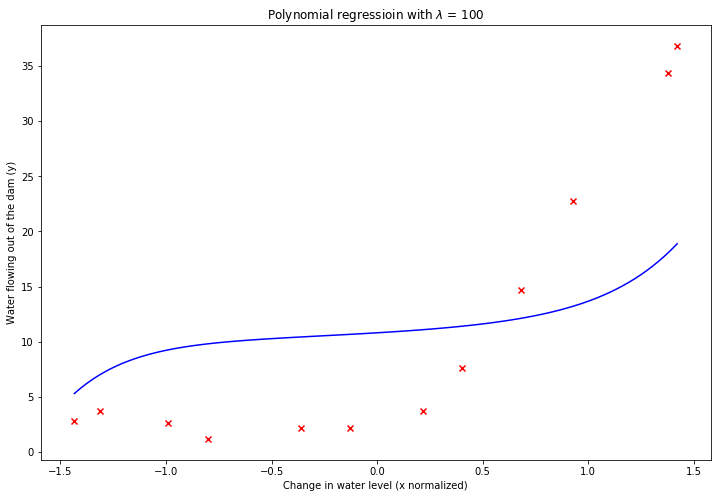

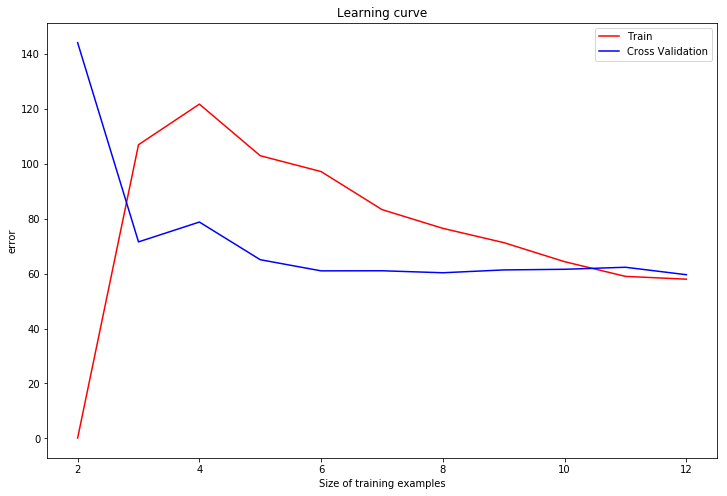

In [77]:
plot_polynomial(X_train_poly, y_train, 100)
learning_curve(X_train_poly, y_train, X_cv_poly, y_cv, 100)

## 5 Selecting best $\lambda$

In [78]:
def get_error_lambda(X_train, y_train, X_cv, y_cv, regs):
    e1, e2 = [], []
    for reg in regs:
        theta = linear_regression(X_train, y_train, reg).x
        e1.append(cost(theta, X_train, y_train))
        e2.append(cost(theta, X_cv, y_cv))
    return np.array(e1), np.array(e2)

In [79]:
regs = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
train_error, cv_error = get_error_lambda(X_train_poly, y_train, X_cv_poly, y_cv, regs)
print(train_error.shape)
print(cv_error.shape)

(10,)
(10,)


Text(0.5, 1.0, 'Error-lambda curve')

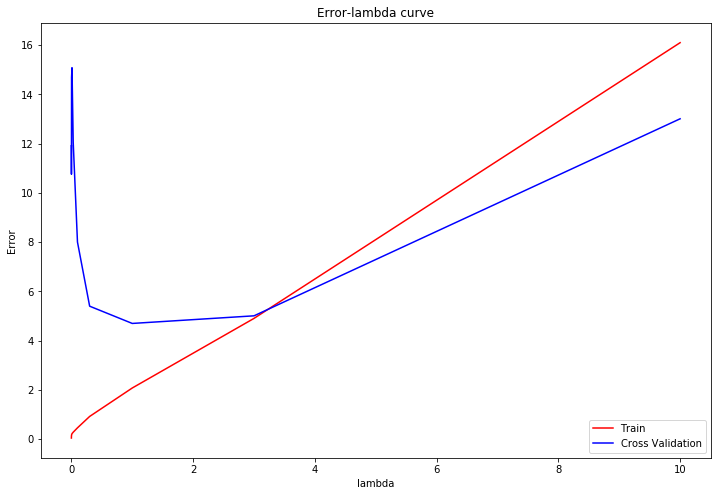

In [80]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(regs, train_error, 'r', label='Train')
ax.plot(regs, cv_error, 'b', label='Cross Validation')
ax.set_xlabel('lambda')
ax.set_ylabel('Error')
ax.legend(loc=4)
ax.set_title('Error-lambda curve')

In [81]:
best_reg = regs[np.argmin(cv_error)]
print('Best λ is {}'.format(best_reg))

Best λ is 1


## 6 Compute test error

In [82]:
theta = linear_regression(X_train_poly, y_train, best_reg).x

X_test, y_test = load_test('ex5data1.mat')
X_test = transform(feature_normalize(poly_features(X_test, 8)))
test_error = cost(theta, X_test, y_test)
print(test_error)

7.466263411199464
